In [1]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
from numpy.fft import fft,ifft,fftfreq
import pandas as pd
from pylab import *
#from sklearn.decomposition import PCA
from math import tan,pi

import antenna_boundary_position as po
import signal_process as sp
import learning_model as lm
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
import target_data_pre as tp
import beamformer as bf
import target_find as tf


In [2]:
pos_file='/Users/charles/Desktop/Target/AntennaPositions2.csv'
ntwk=rf.Network('/Users/charles/Desktop/Target/HL/CalibratedData/IF10k-CNC-Exp0001-calq.s16p') #65


In [3]:
position=tp.linear_array_rerange(pos_file,0,1,2)
position2=po.antenna_pos(pos_file)
print(po.antenma_pos_limit(pos_file))
print(position)


(86.43, -86.43, 106.8, -105.9)
(49.0189162578874, 78.5805819689093)


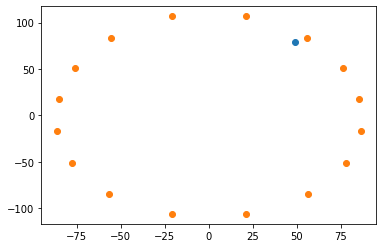

In [4]:
plt.scatter(position[0],position[1])
plt.scatter(position2['x'],position2['y'])
plt.show()

[[-0.00243441  0.00432711 -0.0050784  ...  0.00359433 -0.0024783
   0.00427297]
 [-0.00339998  0.00554252 -0.00680024 ...  0.00400624 -0.00343528
   0.00656094]
 [-0.00626412  0.00558764 -0.00931835 ...  0.00686844 -0.00455094
   0.00696809]]
[[-0.00344555  0.00564448 -0.00492351 ...  0.00346923 -0.00400025
   0.00482113]
 [-0.00344694  0.00564658 -0.00492658 ...  0.00347199 -0.00400232
   0.00482412]
 [-0.00345095  0.00565272 -0.00493564 ...  0.00348017 -0.00400841
   0.00483294]
 ...
 [-0.00537246  0.00347006 -0.00538196 ...  0.00419378 -0.00338881
   0.00366217]
 [-0.00534398  0.00344517 -0.0053478  ...  0.00416636 -0.00336713
   0.00363011]
 [-0.00533443  0.00343682 -0.00533637 ...  0.00415719 -0.00335986
   0.00361938]]


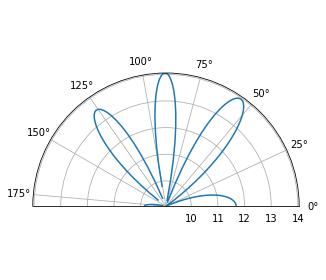

In [6]:
#polar plot

scatter_array=sp.linear_array_scatter(ntwk)[0:3]
#scatter_array=sp.scatter_array_truncated(ntwk)[5:8]
#scatter_array=tp.diff_method(ntwk)[2:5]
print(scatter_array)
y=bf.das_beamformer(pos_file,2,3,4,scatter_array,ntwk)
print(y)
tf.beamformer_polar(y)

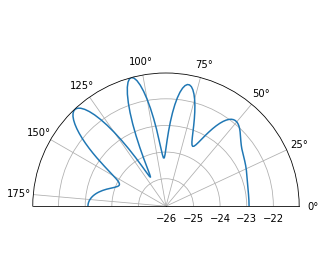

In [7]:
#get all intersections of direction linear equation


coef_array=[]

#full_scatter_array=sp.linear_array_scatter(ntwk)
#full_scatter_array=sp.scatter_array_truncated(ntwk)
full_scatter_array=tp.diff_method(ntwk)

for scatter_index in range(len(full_scatter_array)): 
    if scatter_index<=13:
        #the scatter_array input (3,2001)
        scatter_array=full_scatter_array[scatter_index:scatter_index+3]
        #beamformer array
        beamformer_array=bf.das_beamformer(pos_file,scatter_index,scatter_index+1,scatter_index+2,scatter_array,ntwk)
        #direction linear equation coefficient list
        coef_list=tf.direction_linear_equation(pos_file,scatter_index,scatter_index+1,scatter_index+2,beamformer_array)
    elif scatter_index==14:
        scatter_array=np.array([full_scatter_array[14],full_scatter_array[15],full_scatter_array[0]])
        beamformer_array=bf.das_beamformer(pos_file,scatter_index,scatter_index+1,0,scatter_array,ntwk)
        coef_list=tf.direction_linear_equation(pos_file,scatter_index,scatter_index+1,0,beamformer_array)
    elif scatter_index==15:
        scatter_array=np.array([full_scatter_array[15],full_scatter_array[0],full_scatter_array[1]])
        beamformer_array=bf.das_beamformer(pos_file,scatter_index,0,1,scatter_array,ntwk)
        coef_list=tf.direction_linear_equation(pos_file,scatter_index,0,1,beamformer_array)
    
    coef_array.append(coef_list)

tf.beamformer_polar(beamformer_array)

In [8]:
intersection_list=[]
for i in range(len(coef_array)):
    for j in range(i+1,len(coef_array)):
        inter_coor=tf.intersection_cal(coef_array[i],coef_array[j])
        intersection_list.append(inter_coor)

In [9]:
#filter coordinates out of boundary
max_x,min_x,max_y,min_y=po.antenma_pos_limit(pos_file)

intersection_filter=[]
for i in range(len(intersection_list)):
    intersection=intersection_list[i]
    if intersection[0]>min_x and intersection[0]<max_x:
        if intersection[1]>min_y and intersection[1]<max_y:
            if (intersection[0]**2+intersection[1]**2)<po.intersection_limit(pos_file):
                intersection_filter.append(intersection)

intersection_df=pd.DataFrame(np.array(intersection_filter))

#intersection after Kmeans
select_intersection=tf.kmeans_cluster(intersection_df,7) #21
select_df=pd.DataFrame(np.array(select_intersection))

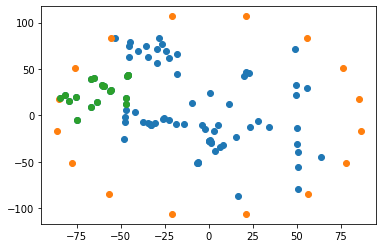

In [10]:
plt.scatter(intersection_df[0],intersection_df[1])
plt.scatter(position2['x'],position2['y'])
plt.scatter(select_df[0],select_df[1])
plt.show()


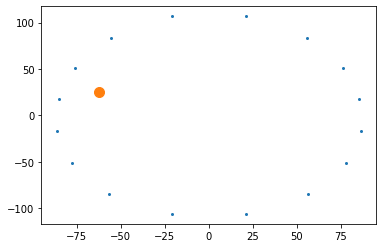

In [11]:
#target show
average_intersection=tf.average_intersection(select_intersection)
plt.scatter(position2['x'],position2['y'],s=4)
plt.scatter(average_intersection[0],average_intersection[1],s=100.)
plt.show()